<a href="https://colab.research.google.com/github/LeyloJohnny/First-ML/blob/main/multicat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 18.3MB/s 
     |████████████████████████████████| 1.2MB 48.7MB/s 
     |████████████████████████████████| 194kB 50.4MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 12.8MB 244kB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *

### Data

The PASCAL dataset can have more than one kind of classified object per image:

In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

Different structure: comma-separated-values (CSV) instead of folder/file names.

We can inspect the CSV file by reading it into a Pandas DataFrame:

In [4]:
#read into pandas dataframe
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


Categories (labels) are shown as a space-delimited string.

### Constructing a DataBlock

PyTorch and fastai have two main classes for representing and accessing a training set or validation set:

    Dataset: A collection that returns a tuple of your independent and dependent variable for a single item
    DataLoader: An iterator that provides a stream of mini-batches, where each mini-batch is a tuple of a batch of independent variables and a batch of dependent variables


fastai provides two classes for bringing your training and validation sets together:

    Datasets: An object that contains a training Dataset and a validation Dataset
    DataLoaders: An object that contains a training DataLoader and a validation DataLoader


#### Create a datablock


In [5]:
#create datablock without parameters
dblock = DataBlock()

In [6]:
##create Datasets object from this, source: our dataframe
dsets = dblock.datasets(df)

In [7]:
#dset contains training and validation set
len(dsets.train),len(dsets.valid)

(4009, 1002)

In [8]:
#example for dependent and independent variables from first item in dset
x,y = dsets.train[0]
x,y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object, fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

Problem: this simply returns a row of the DataFrame, twice. This is because by default, the data block assumes we have two things: input and target. We are going to need to grab the appropriate fields from the DataFrame, which we can do by passing get_x and get_y functions:

In [9]:
#this is how you access the right input/feature (x)
x['fname']

'008663.jpg'

In [12]:
#this is how you access the right target/label (y)
y['labels']

'car person'

In [16]:
#works also the other way around (x and y are the same right now)
x['labels']

'car person'

How to create a datablock from a dataframe using lambda (a shortcut for defining and then referring to a function):

In [18]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('002549.jpg', 'tvmonitor')

**Caution!**

Lambda functions are great for quickly iterating, but they are not compatible with serialization, so we advise you to use the more verbose approach if you want to export your Learner after training (lambdas are fine if you are just experimenting).

More verbose way:

In [19]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('002844.jpg', 'train')

The independent variable will need to be converted into a complete path, so that we can open it as an image, and the dependent variable will need to be split on the space character (which is the default for Python’s split function) so that it becomes a list:

In [20]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/002546.jpg'), ['dog'])

To actually open the image and do the conversion to tensors, we will need to use a set of transforms; block types will provide us with those:

In [21]:
#ImageBlock and MultiCategoryBlock
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

List of zeros with a one at each position where a category is present: *one-hot encoding*

In [24]:
#access the category using torch.where
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['bird']

We have ignored the column is_valid up until now, which means that DataBlock has been using a random split by default. To explicitly choose the elements of our validation set, we need to write a function and pass it to splitter (or use one of fastai's predefined functions or classes). It will take the items (here our whole DataFrame) and must return two (or more) lists of integers:

In [26]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

Ensure same size of data by using *RandomResizeCrop*:

In [27]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

Display sample of data:

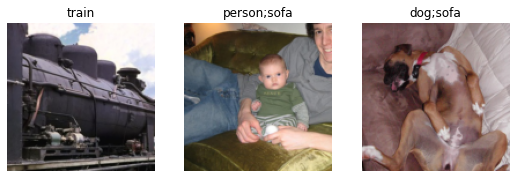

In [28]:
dls.show_batch(nrows=1, ncols=3)

### Binary Cross-Entropy

A Learner object contains four main things: 
1. the model
2. a DataLoaders object
3. an Optimizer
4. the loss function to use

1. we can leverage fastais resnet models
2. is already created
3. we know how to create a SGD optimizer
4. but how to ensure a suitable loss function?

In [30]:
learn = cnn_learner(dls, resnet18)

Grab a mini batch and look at the shape:

In [31]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

We have a batch size of 64, and we need to calculate the probability of each of 20 categories. Here’s what one of those activations looks like:

In [32]:
activs[0]

tensor([ 0.9833, -0.5657, -2.8462, -1.8998, -3.1834, -2.2020,  1.8353,  0.4837,  0.6096, -0.5659,  2.2175,  1.3913,  0.6722,  5.0260,  0.4435, -1.1368, -3.7351, -2.2811,  1.6156, -0.8888],
       grad_fn=<SelectBackward>)

They aren’t yet scaled to between 0 and 1, but we learned how to do that in <>, using the sigmoid function. We also saw how to calculate a loss based on this—this is our loss function from <>, with the addition of log as discussed in the last chapter:

In [34]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, 1-inputs, inputs).log().mean()

Note that because we have a one-hot-encoded dependent variable, we can't directly use `nll_loss` or `softmax` (and therefore we can't use `cross_entropy`):

- `softmax`, as we saw, requires that all predictions sum to 1, and tends to push one activation to be much larger than the others (due to the use of `exp`); however, we may well have multiple objects that we're confident appear in an image, so restricting the maximum sum of activations to 1 is not a good idea. By the same reasoning, we may want the sum to be *less* than 1, if we don't think *any* of the categories appear in an image.
- `nll_loss`, as we saw, returns the value of just one activation: the single activation corresponding with the single label for an item. This doesn't make sense when we have multiple labels.

On the other hand, the `binary_cross_entropy` function, which is just `mnist_loss` along with `log`, provides just what we need, thanks to the magic of PyTorch's elementwise operations. 

Each activation will be compared to each target for each column, so we don't have to do anything to make this function work for multiple columns.


PyTorch already provides this function for us. In fact, it provides a number of versions, with rather confusing names!

F.binary_cross_entropy and its module equivalent nn.BCELoss calculate cross-entropy on a one-hot-encoded target, but do not include the initial sigmoid. Normally for one-hot-encoded targets you'll want F.binary_cross_entropy_with_logits (or nn.BCEWithLogitsLoss), which do both sigmoid and binary cross-entropy in a single function, as in the preceding example.

The equivalent for single-label datasets (like MNIST or the Pet dataset), where the target is encoded as a single integer, is F.nll_loss or nn.NLLLoss for the version without the initial softmax, and F.cross_entropy or nn.CrossEntropyLoss for the version with the initial softmax.

Since we have a one-hot-encoded target, we will use BCEWithLogitsLoss:


In [36]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0654, grad_fn=<AliasBackward>)

We have to use another metric, accuracy function doesn't work with multicategorical data.

In [37]:
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred = inp.argmax(dim=axis)
    return (pred == targ).float().mean()

It just predicts the one with the highest activation (this is what argmax does).

After applying the sigmoid to our activations (to make them between 0 and 1), we need to decide which ones are 0s and which ones are 1s by picking a threshold. Each value above the threshold will be considered as a 1, and each value lower than the threshold will be considered a 0:

In [38]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

Now train the model:

In [39]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.941029,0.678210,0.237849,00:28
1,0.825782,0.537993,0.293048,00:28
2,0.607694,0.183671,0.837669,00:28
3,0.362057,0.103565,0.953028,00:28


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.135586,0.080402,0.962092,00:29
1,0.117774,0.059716,0.971872,00:29
2,0.096971,0.052838,0.975558,00:29


Picking the right threshold is important!

In [40]:
#too low? > fails to select correctly labeled objects
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.05283764749765396,0.9568925499916077]

In [41]:
#too high? > only selects objects with very high confidence
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.05283764749765396,0.9473506212234497]

Get the right threshold?

In [ ]:
#grab predictions once (that's faster)
preds,targs = learn.get_preds()

Then we can call the metric directly. Note that by default get_preds applies the output activation function (sigmoid, in this case) for us, so we'll need to tell accuracy_multi to not apply it:

In [43]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorMultiCategory(0.9664)

We can now use this approach to find the best threshold level:

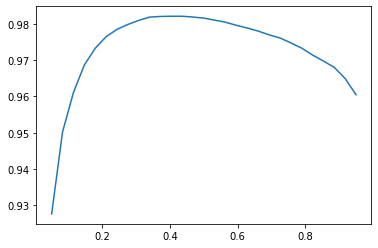

In [46]:
#We're using the validation set to pick a hyperparameter (the threshold), which is the purpose of the validation set
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

# Image Regression

## Predict center of a face in image

### Assemble the data

In [ ]:
#get head pose data set
path = untar_data(URLs.BIWI_HEAD_POSE)

In [49]:
Path.BASE_PATH = path

In [50]:
#what do we have?
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

There are 24 directories numbered from 01 to 24 (they correspond to the different people photographed), and a corresponding .obj file for each (we won't need them here). Let's take a look inside one of these directories:

In [51]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

Inside the subdirectories, we have different frames, each of them come with an image (_rgb.jpg) and a pose file (_pose.txt). We can easily get all the image files recursively with get_image_files, then write a function that converts an image filename to its associated pose file:

In [52]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('24/frame_00036_pose.txt')

Let's have a look at our image:

In [54]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

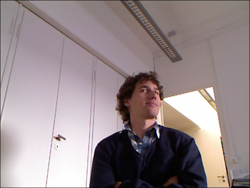

In [59]:
im.to_thumb(250)

In the text file, there's information about the center position of the head. 

In [60]:
#function to extract the head center coordinates from the text file
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [61]:
#this returns the coordinates as a tensor of two items
get_ctr(img_files[0])

tensor([401.1082, 239.5933])

We can pass this function to DataBlock as get_y, since it is responsible for labeling each item. 

In [62]:
#use pointblock for coordinates
#use splitter function that returns true for just one person, resulting in a validation set containing just that person's images
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

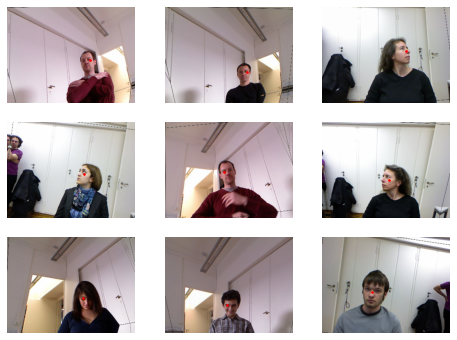

In [63]:
#look at the data
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [64]:
#look at the tensors too:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [71]:
yb[0]

TensorPoint([[-0.3906,  0.0405]], device='cuda:0')

### Train the model

In [72]:
#y range defines by -1 to 1 (coordinates in fastai and PyTorch are always rescaled between -1 and +1)
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

In [73]:
#what loss function are we using here as default?
dls.loss_func

FlattenedLoss of MSELoss()

Find a suitable learning rate: 

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.03981071710586548)

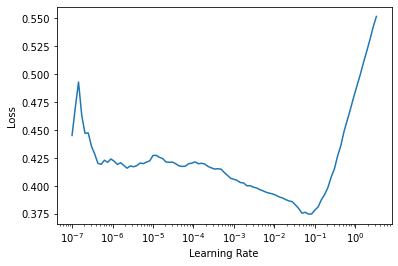

In [77]:
learn.lr_find()

In [78]:
#let's take 1e-2
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.049821,0.018287,02:01


epoch,train_loss,valid_loss,time
0,0.007985,0.004117,02:10
1,0.002902,0.000663,02:13
2,0.001376,0.000055,02:11


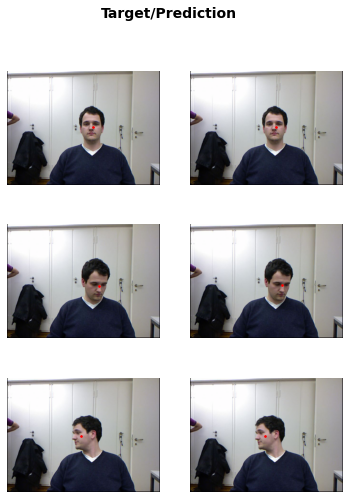

In [79]:
#let's look at the results
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

Loss function is very important!

fastai will automatically try to pick the right one from the data you built, but if you are using pure PyTorch to build your DataLoaders, make sure you think hard when you have to decide on your choice of loss function, and remember that you most probably want:

    nn.CrossEntropyLoss for single-label classification
    nn.BCEWithLogitsLoss for multi-label classification
    nn.MSELoss for regression
